# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

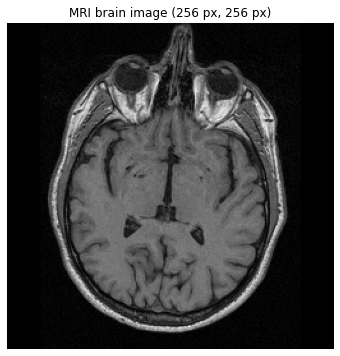

In [2]:
import skimage.io
from skimage import restoration
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

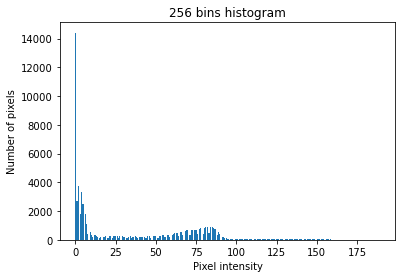

In [3]:
nb_bins = 256

# Display histogram
plt.figure(figsize=(6, 4))
plt.hist(brain_im.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')
plt.show()

In [4]:
def hist_equ(img):
    pixel_nb = img.shape[0]*img.shape[1]
    values, bins = np.histogram(img.ravel(), 256)
    new_values = np.zeros(values.shape)
    new_bins = np.arange(bins.shape[0])
    for j in range(len(bins)-1):
        new_values[j] = (256/pixel_nb)*values[:j].sum()
    return (new_values,new_bins)

def median_filter(img,k=3):
    new_image = np.zeros(img.shape,dtype=np.uint8)
    offset = int((k-1)/2)
    for i in range(offset,img.shape[0]-offset):
        for j in range(offset,img.shape[1]-offset):
            new_image[i,j] = int(np.median(img[i-offset:i+offset+1,j-offset:j+offset+1]))
    return new_image

def median_filter_alt(img,k=3):
    new_image = np.zeros(img.shape)
    offset = int((k-1)/2)
    for i in range(offset,img.shape[0]-offset):
        for j in range(offset,img.shape[1]-offset):
            new_image[i,j] = int(np.median(img[i-offset:i+offset+1,j-offset:j+offset+1]))
    return new_image

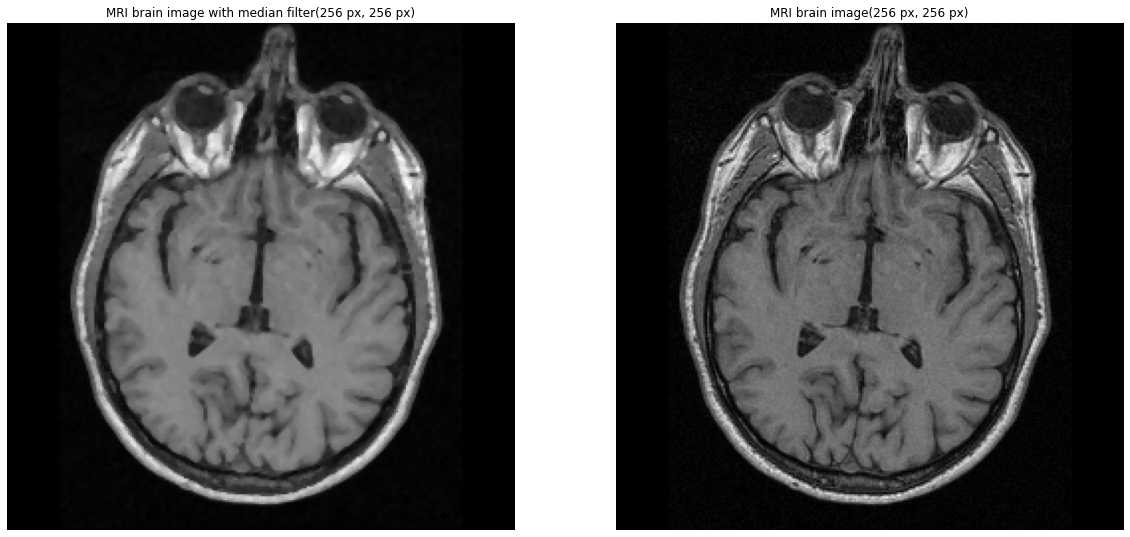

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(median_filter(brain_im,k=3), cmap='gray')
ax[0].set_title('MRI brain image with median filter({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(brain_im, cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

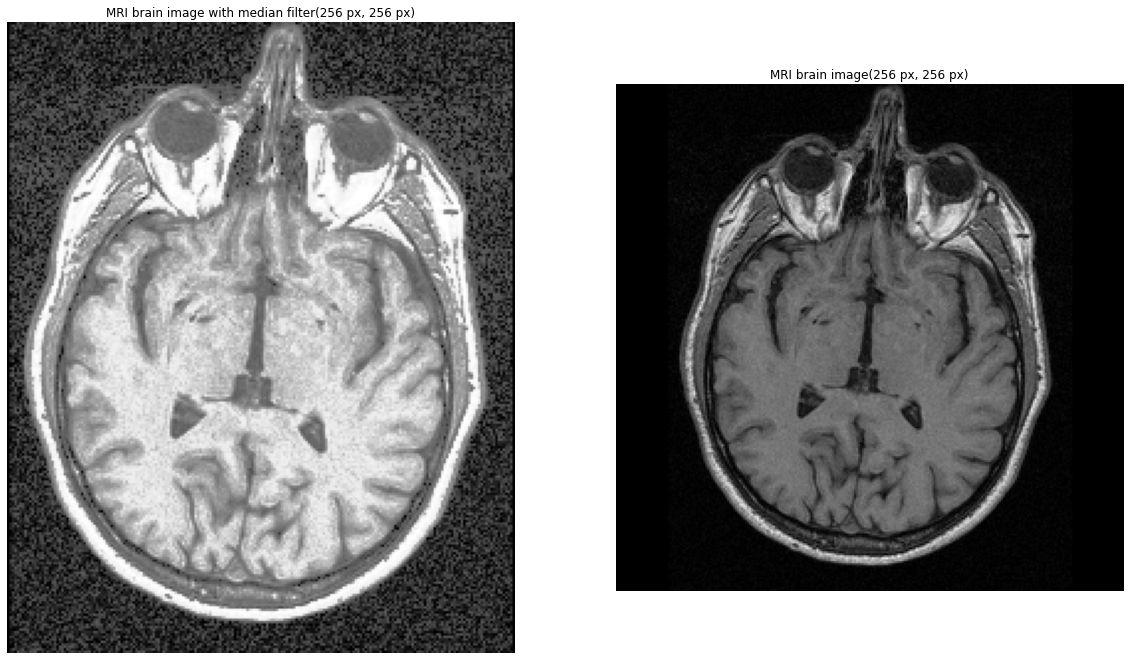

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(cv2.equalizeHist(brain_im)[:,25:-25], cmap='gray')
ax[0].set_title('MRI brain image with median filter({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(brain_im, cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

## Remove noise

In [8]:
from skimage import color, data, restoration
from scipy.signal import convolve2d
psf = np.eye(1)
img = convolve2d(brain_im[:,30:-30], psf, 'same')
deconvolved_img,i = restoration.unsupervised_wiener(img, psf)

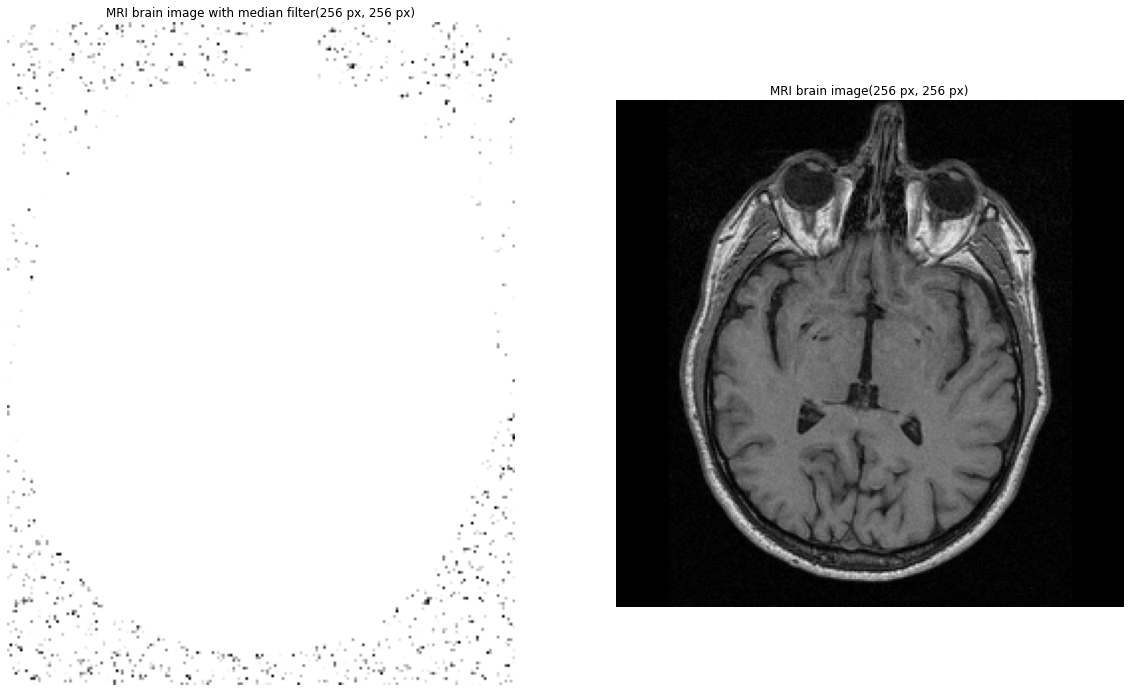

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(deconvolved_img, cmap='gray')
ax[0].set_title('MRI brain image with median filter({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(brain_im, cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

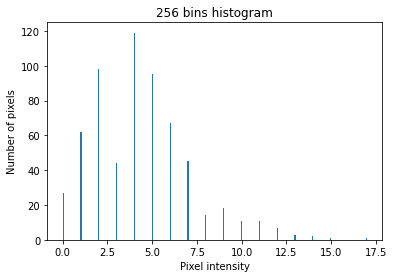

In [10]:
nb_bins = 256

# Display histogram
plt.figure(figsize=(6, 4))
plt.hist(brain_im[26:51,26:51].ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')
plt.show()

In [11]:
from scipy.fft import irfft2, rfft2
a_1 = np.concatenate([brain_im[26:51,26:51]]*15,axis=0)
a_2 = np.concatenate([a_1]*15,axis=1)
a = rfft2(a_2[:256,:256])
b = rfft2(brain_im)
c = b/a
d = irfft2(c)
#brain_im[26:51,26:51]

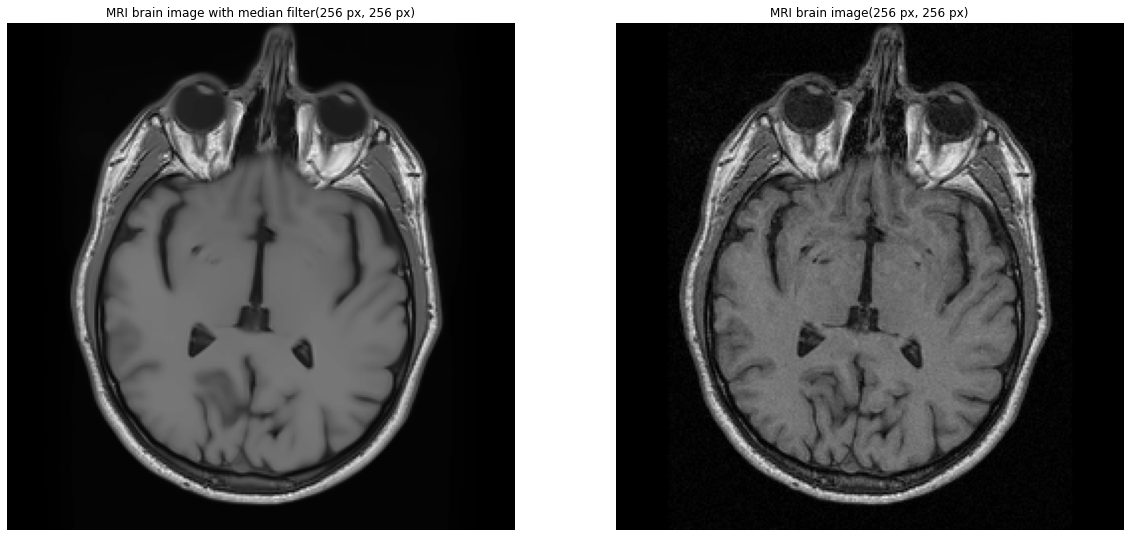

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
smooth = cv2.fastNlMeansDenoising(brain_im,h=10,templateWindowSize=7,searchWindowSize=21)
ax[0].imshow(smooth, cmap='gray')
ax[0].set_title('MRI brain image with median filter({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(brain_im, cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

#### Wiener Filter demo

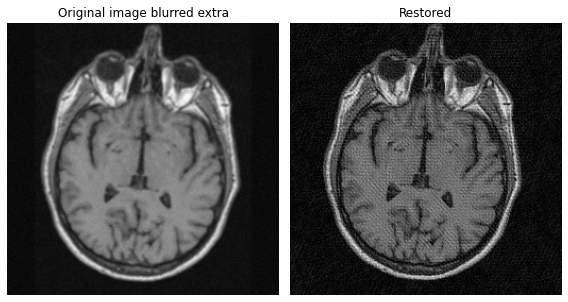

dtype('float64')

In [13]:
# https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/VELDHUIZEN/node15.html

from scipy.signal import convolve2d as conv2
import scipy.fft

rng = np.random.default_rng()

# Unaffected image
im = brain_im

# PSF filter
h_PSF = np.ones((3, 3)) / 4
H_PSF = scipy.fft.fft2(h_PSF, s=im.shape)

# Adding disturbance to image
im = conv2(im, h_PSF, 'same')
noise = 0.05 * im.std() * rng.standard_normal(im.shape)
im += noise 

# Spectras for autocorr
im_autocorr = scipy.signal.correlate2d(im, im,"same")
noise_autocorr = scipy.signal.correlate2d(noise, noise, "same")
im_autocorr_fft = scipy.fft.fft2(im_autocorr)
noise_autocorr_fft = scipy.fft.fft2(noise_autocorr)

# Assembling wiener filter
H_wiener = np.conjugate(H_PSF)/(np.power(np.abs(H_PSF),2) + (noise_autocorr_fft/im_autocorr_fft))

# Restoring using wiener filter
im_fft = scipy.fft.fft2(im)
im_restored_fft = im_fft*H_wiener
im_restored = np.abs(scipy.fft.ifft2(im_restored_fft))

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                       sharex=True, sharey=True)
plt.gray()

ax[0].imshow(im)
ax[0].axis('off')
ax[0].set_title('Original image blurred extra')

ax[1].imshow(im_restored)
ax[1].axis('off')
ax[1].set_title('Restored')

fig.tight_layout()

plt.show()
im.dtype

### 1.2 Region growing (5pts)

In [14]:
# Add your implementation and discussion
def rec_grow(img,x,y,l,tr):
    if img[x,y] > tr and (x,y) not in l:
        l.append((x,y))
        for p in neighbours(img,x,y):
            rec_grow(img,p[0],p[1],l,tr)
        
def neighbours(img,x,y):
    neighbours = []
    for i in range(-1,2):
        for j in range(-1,2):
            if not (i==0 and j==0):
                if in_image(img,x+i,y+j):
                    neighbours.append((x+i,y+j))
    return neighbours

def in_image(img,x,y):
    return x >= 0 and y >= 0 and x < img.shape[0] and y < img.shape[1]

def iterative_grow(img,x,y,tr):
    candidate = []
    region = []
    visited = set()
    candidate.append((x,y))
    if not in_image(img,x,y):
        raise Exception("The seed given is not in the image boundaries.")
    while len(candidate) > 0:
        c = candidate[-1]
        x_c, y_c = c
        if img[x_c,y_c] > tr and (x_c,y_c) not in visited:
            visited = visited.union(set([tuple((x_c,y_c))]))
            region.append(c)
            candidate.pop()
            for new_c in neighbours(img,x_c,y_c):
                candidate.append(new_c)
        else:
            candidate.pop()
    return region

In [15]:
"""
brain_segmentation = np.zeros(brain_im.shape,dtype=np.int32)
for i in iterative_grow(median_filter(brain_im),100,100,70):
    brain_segmentation[i[0],i[1]] = 255
"""
brain_segmentation = np.zeros(smooth.shape,dtype=np.int32)
for i in iterative_grow(smooth,100,100,69):
    brain_segmentation[i[0],i[1]] = 255

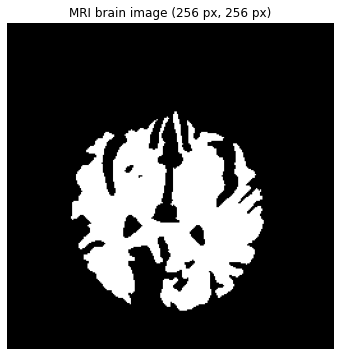

In [16]:
# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_segmentation,"gray")
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.3 Contour detection (SMOOTH)(5pts)

In [19]:
def sobel_filter(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    final = cv2.addWeighted(grad, 0.2, img, 0.8, 0)
    return final

def LoG(img,sigma=1,tr=150):
    gaussian = cv2.GaussianBlur(img,(0,0),sigma)
    log = cv2.Laplacian(gaussian, cv2.CV_64F)
    log = median_filter_alt(log,k=5)
    edge_mask = zero_crossing(log,tr)
    return edge_mask

def enhanced_contrast(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    a = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    b = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
    enhanced = img + a - b
    return enhanced

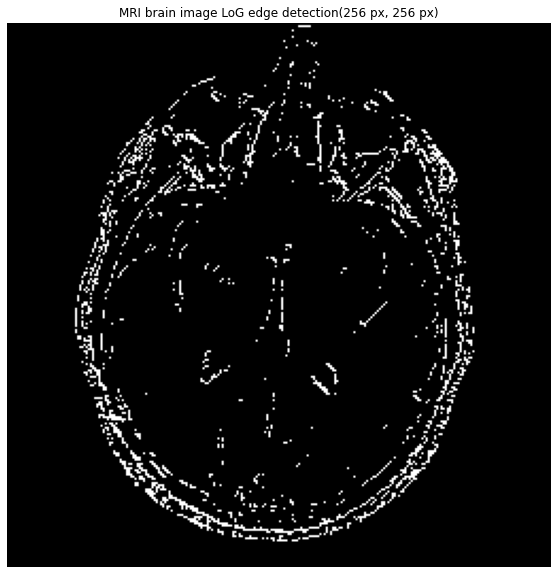

In [24]:
def zero_crossing(img,tr=0):
    zero_crossing = np.zeros(img.shape,dtype=np.float32)
    max_diff = np.abs(img.max() - img.min())
    for i in range(1,img.shape[0]):
        for j in range(1,img.shape[1]):
            local_window = img[i-1:i+2,j-1:j+2]
            local_min = local_window.min()
            local_max = local_window.max()
            if local_min < 0 and local_max > 0 and (local_max - local_min  > tr) :
                zero_crossing[i,j] = 1
    return zero_crossing

def zero_crossing_2(img,tr=0):
    sign_shift_hor = np.zeros(img.shape,dtype=np.float32)
    sign_shift_ver = np.zeros(img.shape,dtype=np.float32)
    abs_diff_hor = np.zeros(img.shape,dtype=np.float32)
    abs_diff_ver = np.zeros(img.shape,dtype=np.float32)
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    # Get sign shifts and combine
    sign_shift_hor[img > 0] = 1
    sign_shift_ver[img > 0] = 1
    
    sign_shift_hor[:,1:img_width] = np.abs(sign_shift_hor[:,1:img_width] - sign_shift_hor[:,0:img_width-1])
    sign_shift_ver[1:img_height,:] = np.abs(sign_shift_ver[1:img_height,:] - sign_shift_ver[0:img_height-1,:])
    
    sign_shift = sign_shift_hor + sign_shift_ver
    
    # Get absolute difference
    abs_diff_hor[:,1:img_width] = np.abs(img[:,1:img_width] - img[:,0:img_width-1])
    abs_diff_ver[1:img_height,:] = np.abs(img[1:img_height,:] - img[0:img_height-1,:])
        
    # Threshold the differences and combine
    abs_diff_hor[abs_diff_hor < tr] = 0
    abs_diff_hor[abs_diff_hor >= tr] = 1
    abs_diff_ver[abs_diff_ver < tr] = 0
    abs_diff_ver[abs_diff_ver >= tr] = 1
    
    abs_diff = abs_diff_hor + abs_diff_ver
    abs_diff[abs_diff > 0] = 1
    
    # Use sign shift mask and get final zero crossings
    abs_diff[sign_shift <= 0] = 0
    
    return abs_diff

# Test
gaussian = cv2.GaussianBlur(median_filter(brain_im,k=3),(0,0),0.1)
log = cv2.Laplacian(gaussian, cv2.CV_64F)
test = zero_crossing_2(log,60)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(zero_crossing_2(log,60), cmap='gray')
ax.set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax.axis('off')

plt.show()

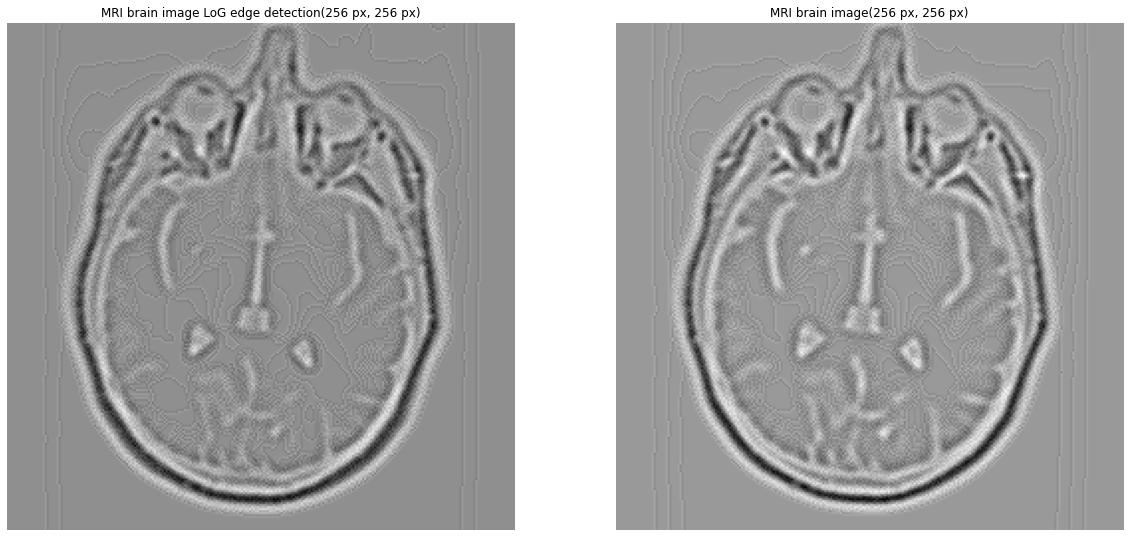

In [20]:
gaussian = cv2.GaussianBlur(sobel_filter(smooth),(0,0),2)
log = cv2.Laplacian(gaussian, cv2.CV_64F)
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(log, cmap='gray')
ax[0].set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
gaussian = cv2.GaussianBlur(smooth,(0,0),2)
log = cv2.Laplacian(gaussian, cv2.CV_64F)
ax[1].imshow(log, cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

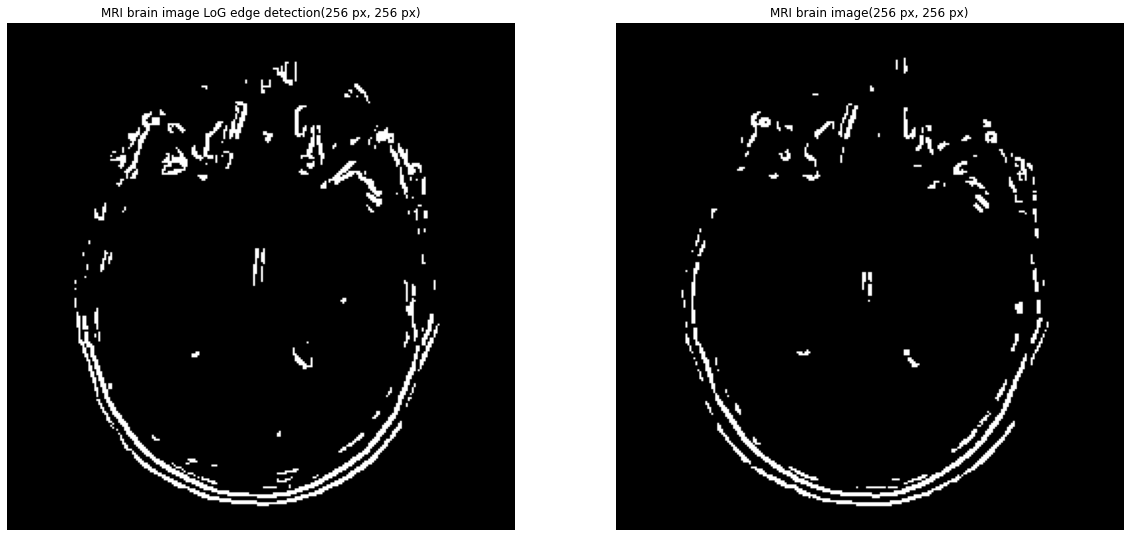

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(LoG(smooth,sigma=1,tr=10), cmap='gray')
ax[0].set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(LoG(sobel_filter(smooth),sigma=1,tr=10), cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

### 1.3 Contour detection (5pts)

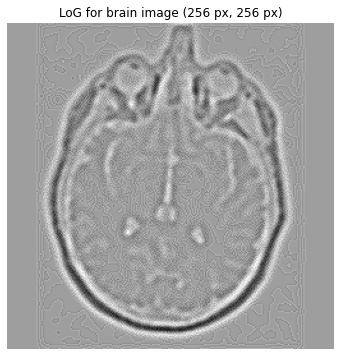

In [26]:
gaussian = cv2.GaussianBlur(median_filter(sobel_filter(brain_im),k=5),(0,0),2)
log = cv2.Laplacian(gaussian, cv2.CV_64F)
# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(log,"gray")
ax.set_title('LoG for brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

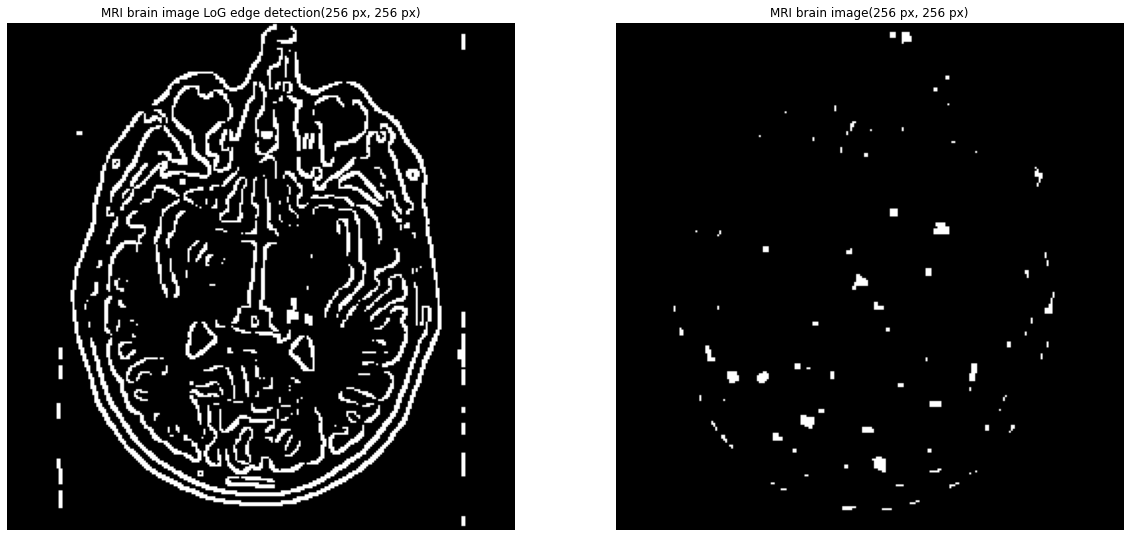

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(LoG(median_filter(brain_im,k=3),sigma=2,tr=0), cmap='gray')
ax[0].set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(LoG(sobel_filter(median_filter(brain_im)),sigma=5,tr=0), cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

### 1.4 Additional method (5pts)

k-means

In [26]:
import k_means
%load_ext autoreload
%autoreload 2

In [27]:
compressed_brain_im = k_means.kmean_compression(smooth,k=4)

Current image: the shape of image=(65536, 1), the data type=float64.
The current iteration of kmeans is: 0, the average loss is 429.14845275878906.
The current iteration of kmeans is: 10, the average loss is 113.66421770825558.
The current iteration of kmeans is: 20, the average loss is 57.8692578919953.


In [28]:
mask = compressed_brain_im == 76

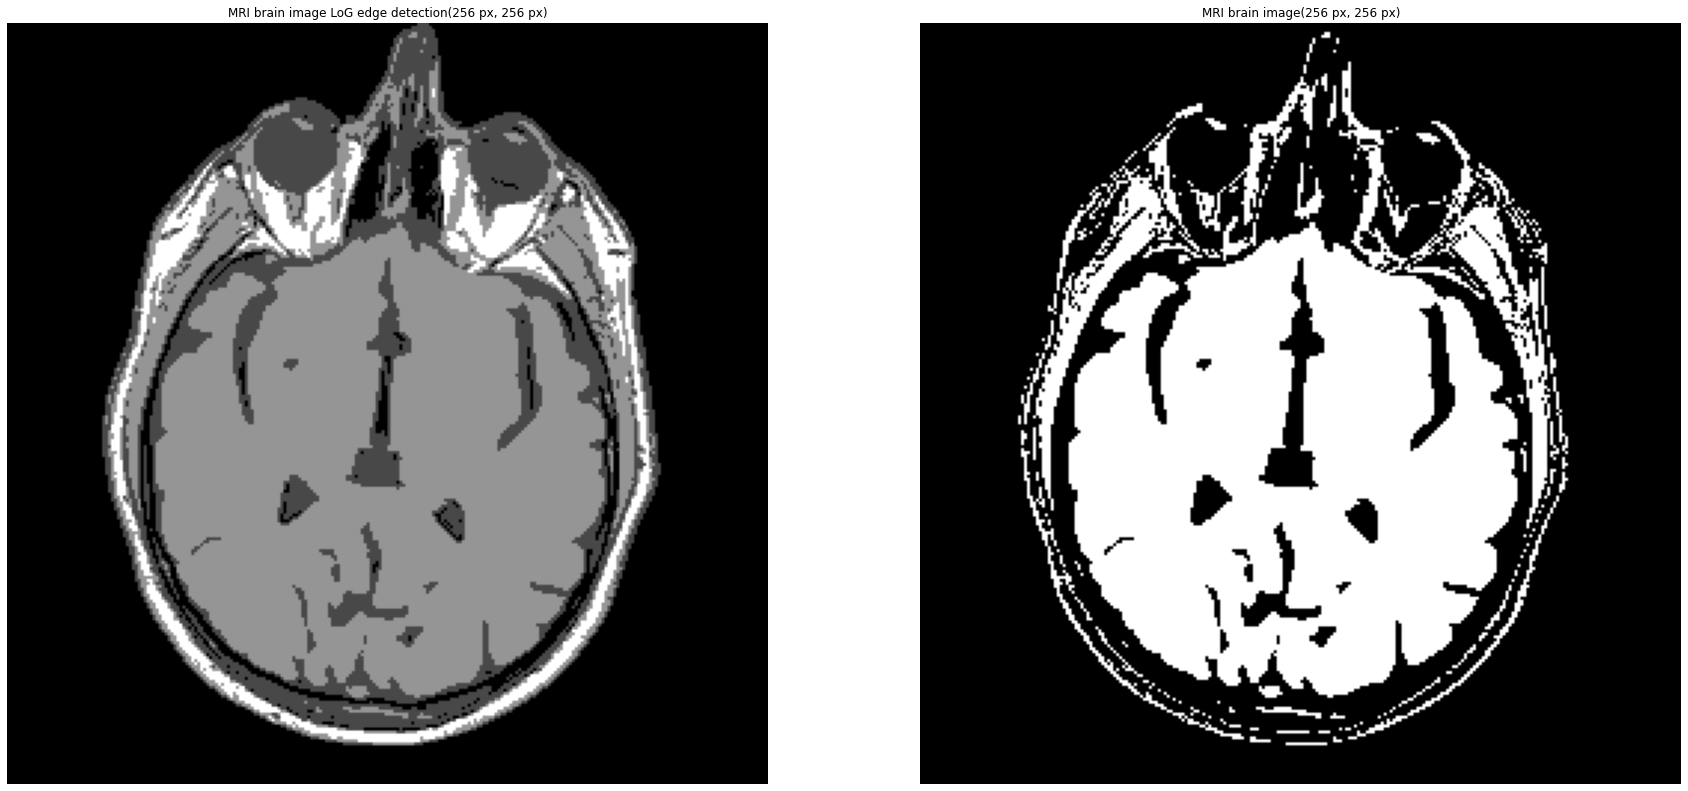

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
ax[0].imshow(compressed_brain_im, cmap='gray')
ax[0].set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

In [30]:
def aggregate(img,x,y,color):
    candidate = []
    region = []
    visited = set()
    candidate.append((x,y))
    if not in_image(img,x,y):
        raise Exception("The seed given is not in the image boundaries.")
    while len(candidate) > 0:
        c = candidate[-1]
        x_c, y_c = c
        if img[x_c,y_c] == color and (x_c,y_c) not in visited:
            visited = visited.union(set([tuple((x_c,y_c))]))
            region.append(c)
            candidate.pop()
            for new_c in neighbours(img,x_c,y_c):
                candidate.append(new_c)
        else:
            candidate.pop()
    return region

In [31]:
brain_segmentation = np.zeros(compressed_brain_im.shape,dtype=np.int32)
for i in aggregate(compressed_brain_im,100,100,76):
    brain_segmentation[i[0],i[1]] = 255

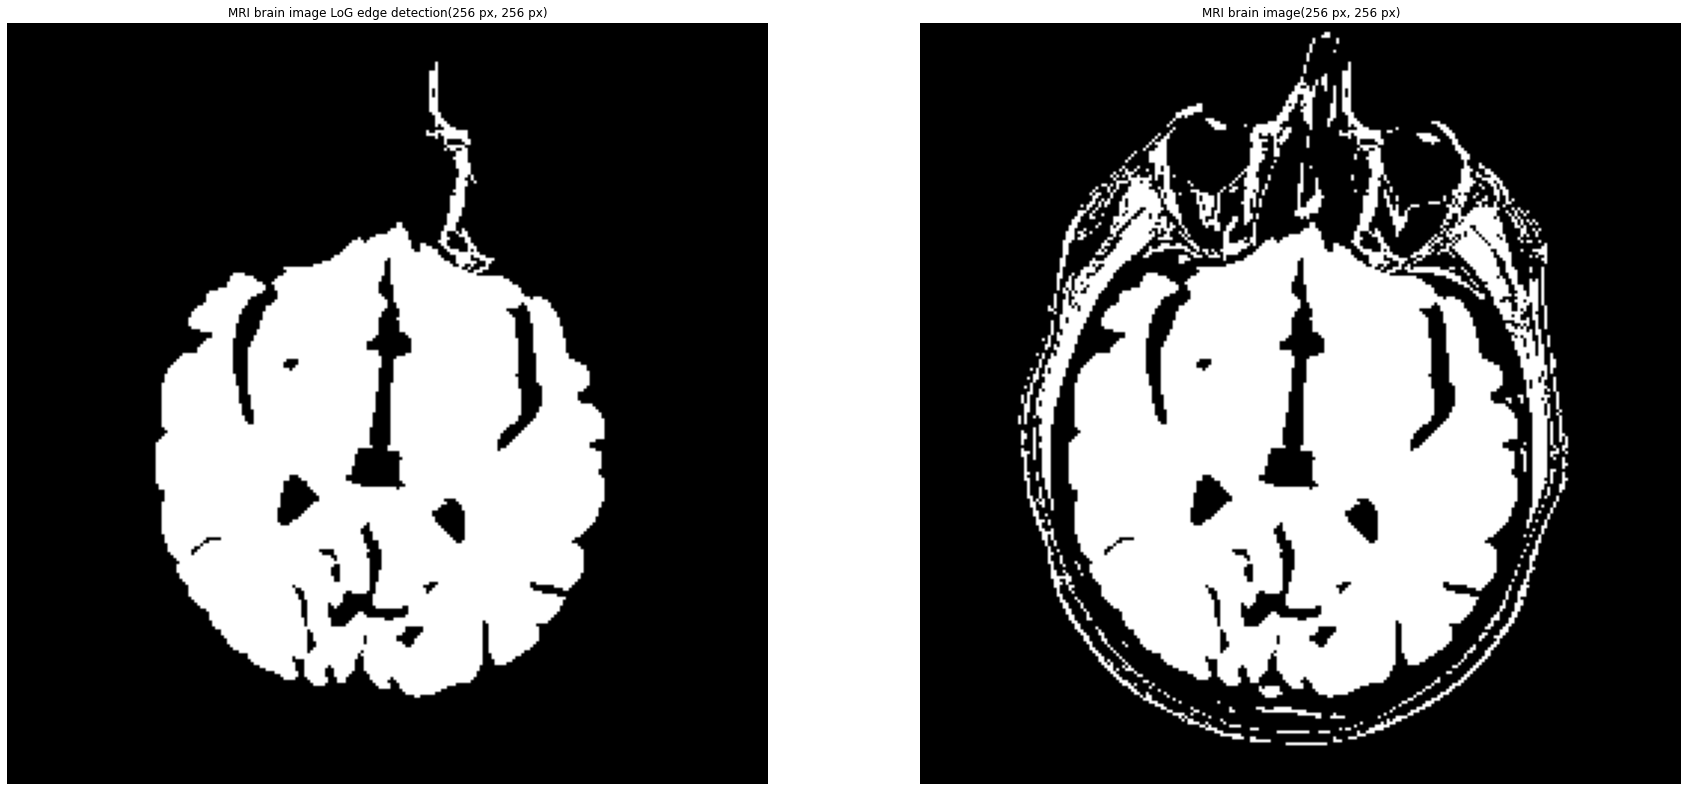

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
ax[0].imshow(brain_segmentation, cmap='gray')
ax[0].set_title('MRI brain image LoG edge detection({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('MRI brain image({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

---

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [ ]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [ ]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [ ]:
# Add your implementation and discussion